WIP
Citations: Andrew Lucas: Ising formulations of many NP Problems. arXiv:1302.5843. 
https://arxiv.org/abs/1302.5843

Ising machine: Number Partitioning

Number partitioning is an algorithm which partitions a set of numbers into two
sets such that both sets add up to the same amount. 

In [2]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import numba
import math


In [ ]:
# generate a random set of N positive whole numbers
def generate_data(N):
    return np.random.randint(1, N, N) # low, high, size

N = 1000
data = generate_data(N)
print("data: ", data)
print("length:", len(data))
print("Data generated.")

data:  [19 95 91 85 44 55  5 38 23 66 53  2 23 45 60 66 85 44 87 80 25 10 17 26
 23 35 94 15 12 43 55 78  6 55  6 29 45 56 30 75 38 12 59 51 54 35 84 69
 60 82 48 34 34 94 94 57 15 65 70 80 61 18 41 15 58 79 98 22 18 38 33 49
 43 34 46 34 34 25 61 38 85 53 82 68 50 35 51 72  4 62 23 52 45 44 71 34
 75 59 27 51]
length: 100
Data generated.


In [106]:
# generate an initial N x 1 vector of spins which are -1 or 1
@numba.njit
def generate_spins(N):
    return np.random.choice(np.array([-1, 1], dtype=np.int64), size=N) # 1D array, size. generates random sample

vector = generate_spins(N)
print(vector)

[ 1  1  1 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1  1  1  1 -1  1  1 -1
 -1  1 -1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1 -1
 -1  1  1 -1  1  1  1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1
  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1  1  1
 -1 -1  1 -1]


In [107]:
from numba.typed import List
# partitions numbers randomly into two groups based on the spin vector
@numba.njit(nopython=True)
def get_groups(numbers_set, spin_vector):
    N = len(spin_vector)
    
    set_A = List()
    set_B = List()

    for n in range(N):
        if spin_vector[n] == 1:
            set_A.append(numbers_set[n])
        elif spin_vector[n] == -1: 
            set_B.append(numbers_set[n])
    return set_A, set_B

@numba.njit(nopython=True)
def get_sums(set_A, set_B):
    sum_A = 0
    sum_B = 0
    for a in set_A:
        sum_A += a
    for b in set_B:
        sum_B += b   
    return sum_A, sum_B

set_A, set_B = get_groups(data, vector) # data, vector generated previously

print("set A: ", set_A)
print("set_B", set_B)

sum_A, sum_B = get_sums(set_A, set_B)
print("sum A: ", sum_A)
print("sum B: ", sum_B)

set A:  [19, 95, 91, 23, 53, 2, 23, 45, 44, 87, 80, 10, 17, 35, 15, 12, 55, 78, 55, 6, 29, 56, 30, 75, 38, 54, 84, 82, 48, 34, 94, 94, 57, 65, 61, 58, 98, 18, 33, 43, 46, 34, 34, 25, 61, 85, 50, 72, 62, 23, 52, 45, 71, 34, 27]
set_B [85, 44, 55, 5, 38, 66, 60, 66, 85, 25, 26, 23, 94, 43, 6, 45, 12, 59, 51, 35, 69, 60, 34, 15, 70, 80, 18, 41, 15, 79, 22, 38, 49, 34, 38, 53, 82, 68, 35, 51, 4, 44, 75, 59, 51]
sum A:  2717
sum B:  2107


/Users/aliya/DIMPLE/isingmodel/.venv/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [ ]:
def outer_prod(data):
    S = np.array(data)
    N = len(S)
    J = np.outer(S, S)
    
    return J

# J = outer_prod(data)
print("J:", J)
# A is a constant for the Hamiltonian
A = 1

# H(s) = s^T * J * s
def compute_init_energy(J, s):
    return s @ J @ s # dimensions are handled automatically.


def compute_delta_energy(a, s, i):
    summation = np.sum(a[i] * a * s) # sum across all j 
    return - 2 * s[i] * summation

J: [[ 361 1805 1729 ... 1121  513  969]
 [1805 9025 8645 ... 5605 2565 4845]
 [1729 8645 8281 ... 5369 2457 4641]
 ...
 [1121 5605 5369 ... 3481 1593 3009]
 [ 513 2565 2457 ... 1593  729 1377]
 [ 969 4845 4641 ... 3009 1377 2601]]


In [108]:
@numba.jit(nopython=True)
def compute_sum_difference(a_vector, spin_vector):
    # we trivially define the energy as the absolute value of the difference in
    # sum between the two sets
    set_A, set_B = get_groups(a_vector, spin_vector)
    sum_A, sum_B = get_sums(set_A, set_B)
    return abs(sum_A - sum_B)

print("Initial energy:", compute_sum_difference(data, vector))




Initial energy: 610


In [114]:
@numba.njit(
    numba.types.Tuple((
        numba.types.int64[:],  
        numba.types.int64,   
        numba.types.int64,   
        numba.types.int64[:],  
        numba.types.ListType(numba.types.int64),  
        numba.types.ListType(numba.types.int64)   
    ))(
        numba.types.int64[:],  
        numba.types.int64[:],  
        numba.types.float64,     
        numba.types.int64       
    ),
    nopython=True, parallel=True, fastmath=True, nogil=True
)
# nopython - native types must be inferred by compiler. Python C API is not accessed. 
def metropolis(a_vector, spin_vector, temp, num_steps):
    N = len(a_vector)
    # J = outer_prod(a_vector)  # Compute the outer product of the data vector
    E_i = compute_sum_difference(a_vector, spin_vector)  # Initial energy difference
    current_energy = E_i  # Current energy difference, scalars are immutable
    lowest_energy = current_energy
    best_sort = spin_vector.copy()
    print("Initial energy:", current_energy)

    current_energies = List()
    best_energies = List()
    

    for step in range(num_steps):
        # choose a random number to switch into the other group
        i = np.random.randint(0, N)
        spin_vector[i] *= -1
        # compute the change in energy that would result from flipping to the
        # other group
        new_E = compute_sum_difference(a_vector, spin_vector)
        # print delta_E for first couple of steps only, debugging
        if step < 10:
            print(f"Step {step}: new_E = {new_E}")

        # if difference in sums is less than curr difference in sums, apply this
        # change or accept it with a probability

        if (new_E < current_energy) or (np.random.rand() < np.exp(-new_E / temp)):
            if step < 10:
                print("Accepted this delta!")
            # if the energy change is negative, accept the change or accept with a probability.
            # if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / temp):
            current_energy = new_E  # Update the current energy
            # If the current energy is lower than the best found so far
            if new_E < lowest_energy:
                lowest_energy = current_energy
                best_sort = spin_vector.copy()
        else:
            # flip the spin back to its original state
            spin_vector[i] *= -1  # Revert the spin change

        # Store the current energy for plotting or analysis
        current_energies.append(current_energy)
        best_energies.append(lowest_energy)

    return best_sort, lowest_energy, current_energy, spin_vector, current_energies, best_energies


temp = 0.5
num_steps = 100
spin_vector = generate_spins(N)
a_vector = generate_data(N)

# Initial Groups and Sums
set_A, set_B = get_groups(a_vector, spin_vector)
sum_A, sum_B = get_sums(set_A, set_B)

print("Initial sum A:", sum_A)
print("Initial sum B:", sum_B)
print("Initial absolute difference:", np.absolute(sum_A - sum_B))


best_spin_vec, best_energy, current_energy, current_spin_vec, curr_energies, best_energies = metropolis(a_vector, spin_vector, temp, num_steps)

# print("Best sort:", best_sort)
print("Best energy:", best_energy)
print("Current energy:", current_energy)
# print("Final spin vector:", spin_vec)

# find the groups and sums
set_A, set_B = get_groups(a_vector, current_spin_vec)
sum_A, sum_B = get_sums(set_A, set_B)


print("Final sum A:", sum_A)
print("Final sum B:", sum_B)
print("Final absolute difference:", np.absolute(sum_A - sum_B))

# best results
set_A, set_B = get_groups(a_vector, best_spin_vec)
sum_A, sum_B = get_sums(set_A, set_B)

print("Best sum A:", sum_A)
print("Best sum B:", sum_B)
print("Best absolute difference:", np.absolute(sum_A - sum_B))



/Users/aliya/DIMPLE/isingmodel/.venv/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/aliya/DIMPLE/isingmodel/.venv/lib/python3.11/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/m8/l24rcsrx7cndr07cnvmy2c6c0000gn/T/ipykernel_29814/2195249962.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


Initial sum A: 2455
Initial sum B: 2631
Initial absolute difference: 176
Initial energy: 176
Step 0: new_E = 98
Accepted this delta!
Step 1: new_E = 26
Accepted this delta!
Step 2: new_E = 20
Accepted this delta!
Step 3: new_E = 84
Step 4: new_E = 72
Step 5: new_E = 164
Step 6: new_E = 92
Step 7: new_E = 62
Step 8: new_E = 130
Step 9: new_E = 72
Best energy: 2
Current energy: 2
Final sum A: 2544
Final sum B: 2542
Final absolute difference: 2
Best sum A: 2544
Best sum B: 2542
Best absolute difference: 2


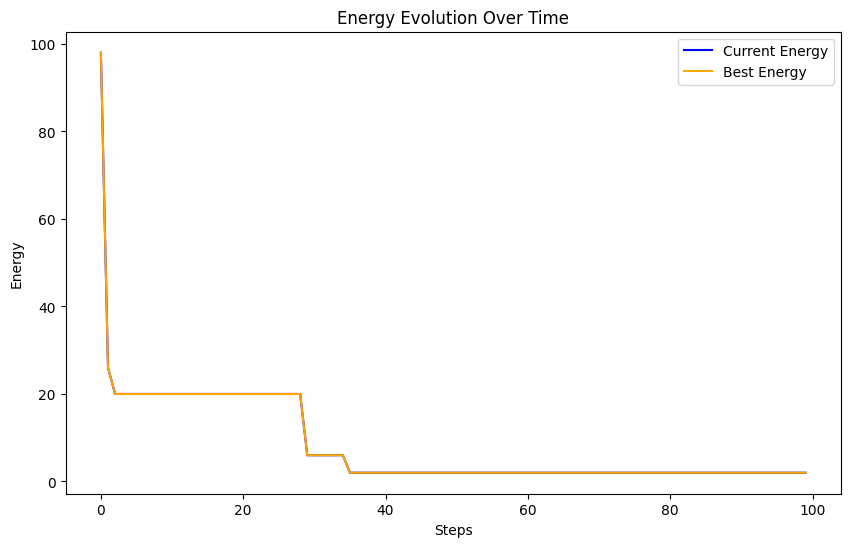

In [115]:
# Plotting the results, how the current and best energy change over time steps
plt.figure(figsize=(10, 6))
plt.plot(range(num_steps), curr_energies, label='Current Energy', color='blue')
plt.plot(range(num_steps), best_energies, label='Best Energy', color='orange')
plt.xlabel('Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution Over Time')
plt.legend()
plt.show()